### Setup 

In this section we define our target trial estimands for two scenarios:
- **Per-protocol (PP):** Focused on patients adhering strictly to the treatment protocol.
- **Intention-to-treat (ITT):** Analyses based on the treatment as assigned regardless of adherence.

We also create directories using Python’s `tempfile` module to store model outputs or intermediate files for later inspection.

In [286]:
import os
import pandas as pd
import tempfile

# Define the estimands
estimand_pp = "PP"  # Per-protocol
estimand_itt = "ITT"  # Intention-to-treat

# Create directories to save files for later inspection
trial_pp_dir = os.path.join(tempfile.gettempdir(), "trial_pp")
os.makedirs(trial_pp_dir, exist_ok=True)

trial_itt_dir = os.path.join(tempfile.gettempdir(), "trial_itt")
os.makedirs(trial_itt_dir, exist_ok=True)

# The data_censored.csv file will be used later for analysis.

### Data Preparation

In this section we load the observational data from the `data_censored.csv` file which will be used for the target trial emulation. 
The dataset includes columns such as `id`, `period`, `treatment`, `x1`, `x2`, `x3`, `x4`, `age`, `age_s`, `outcome`, `censored`, and `eligible`.

We then define a helper function `set_data` to associate specific columns with their roles in the trial data. 

For the Per-protocol analysis, the dataset is assigned to the `trial_pp` object using a pipe-like style, while for the ITT analysis, a standard function call is used.

In [287]:
# Load the observational data
data_censored = pd.read_csv('Data/data_censored.csv')
print(data_censored.head())  # display first few rows


   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  


In [288]:
# Define Per-protocol (PP) dataset with data included
trial_pp = {
    "data": data_censored,
    "id": "id",
    "period": "period",
    "treatment": "treatment",
    "outcome": "outcome",
    "eligible": "eligible"
}

# Define Intention-to-Treat (ITT) dataset with data included
trial_itt = {
    "data": data_censored,
    "id": "id",
    "period": "period",
    "treatment": "treatment",
    "outcome": "outcome",
    "eligible": "eligible"
}

# Compute total observations and unique patients
n_obs = len(data_censored)
n_patients = data_censored['id'].nunique()

# Get the first 2 rows and last 2 rows of the data
head_df = data_censored.head(2)
tail_df = data_censored.tail(2)

def print_data_showcase(data, estimand_label):
    # Compute total observations and unique patients
    n_obs = len(data)
    n_patients = data['id'].nunique()
    
    # Get the first 2 rows and last 2 rows of the data
    head_df = data.head(2)
    tail_df = data.tail(2)
    
    # Manually construct header strings with column names and types (as in provided example)
    print("Trial Sequence Object")
    print("Estimand: " + estimand_label)
    print("\nData:")
    print("  - N: {} observations from {} patients".format(n_obs, n_patients))
    print("         id period treatment    x1           x2   x3        x4   age      age_s")
    print("      <int> <int>     <num> <num>        <num> <int>     <num> <num>      <num>")
    print(head_df.to_string(index=True))
    print("---")
    print(tail_df.to_string(index=True))
    # For the outcome part, print outcome, censored, eligible columns similarly:
    print("\n      outcome censored eligible")
    print("        <num>    <int>    <num>")
    head_outcome = head_df[["outcome", "censored", "eligible"]]
    tail_outcome = tail_df[["outcome", "censored", "eligible"]]
    print(head_outcome.to_string(index=True))
    print("---")
    print(tail_outcome.to_string(index=True))
    print("\n" + "-"*80 + "\n")

# Print showcase for Per-protocol (PP) trial
print_data_showcase(trial_pp["data"], "Per-protocol")

# Print showcase for Intention-to-treat (ITT) trial
print_data_showcase(trial_itt["data"], "Intention-to-treat")


Trial Sequence Object
Estimand: Per-protocol

Data:
  - N: 725 observations from 89 patients
         id period treatment    x1           x2   x3        x4   age      age_s
      <int> <int>     <num> <num>        <num> <int>     <num> <num>      <num>
   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  censored  eligible
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0         0         1
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0         0         0
---
     id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  censored  eligible
723  99       6          1   1 -0.033762   1  0.575268   71  3.000000        0         0         0
724  99       7          0   0 -1.340497   1  0.575268   72  3.083333        1         0         0

      outcome censored eligible
        <num>    <int>    <num>
   outcome  censored  eligible
0        0         0         1
1        0         0        

## Weight Models and Censoring

In this step we adjust for informative censoring by applying inverse probability of censoring weights (IPCW). Time-to-event models are constructed to estimate the probability that an observation is not censored, and these probabilities are later used to compute stabilized weights. The configuration of these weight models is stored in the trial objects, while the actual model fitting is deferred until a function such as `calculate_weights()` is invoked.

- **Censoring Due to Treatment Switching (PP only):**  
  For the Per-protocol estimand, separate models are specified for the numerator (using a limited set of covariates such as age) and the denominator (using an extended set like age, x1, and x3). A dummy model fitter, simulating logistic regression, is used to configure the weight models without immediately fitting them.

- **Other Informative Censoring:**  
  For both PP and ITT, models are defined to estimate the probability of remaining uncensored. This involves specifying the censoring event (e.g., the "censored" column) along with numerator and denominator models (e.g., using x2 in the numerator vs. x2 + x1 in the denominator) and an option to pool models. The configurations are stored, and the models are fit later when needed.

In [289]:
# Define a dummy model fitter to simulate fitting using logistic regression
class StatsGLMLogit:
    def __init__(self, save_path):
        self.save_path = save_path
    def __repr__(self):
        return f"te_stats_glm_logit (save_path={self.save_path})"

# Function to set switch weight model (used only for PP)
def set_switch_weight_model(trial, numerator, denominator, model_fitter):
    trial["switch_weights_config"] = {
         "numerator_formula": f"treatment ~ {numerator}",
         "denominator_formula": f"treatment ~ {denominator}",
         "model_fitter": model_fitter,
         "note": "Weight models not fitted. Use calculate_weights()"
    }
    return trial

# Function to set censor weight model for informative censoring
def set_censor_weight_model(trial, censor_event, numerator, denominator, pool_models, model_fitter):
    trial["censor_weights_config"] = {
         "censor_event": censor_event,
         "numerator_formula": f"1 - {censor_event} ~ {numerator}",
         "denominator_formula": f"1 - {censor_event} ~ {denominator}",
         "pool_models": pool_models,
         "model_fitter": model_fitter,
         "note": "Weight models not fitted. Use calculate_weights()"
    }
    return trial

# Apply treatment switching weight model for PP and assign to a distinct variable.
trial_pp_switch = set_switch_weight_model(
    trial_pp,
    numerator="age",
    denominator="age + x1 + x3",
    model_fitter=StatsGLMLogit(save_path=os.path.join(trial_pp_dir, "switch_models"))
)
print("trial_pp_switch weights config (treatment switching):")
print(trial_pp_switch["switch_weights_config"])

# Apply censor weight model on a copy of PP to keep it separate.
trial_pp_censor = set_censor_weight_model(
    trial_pp.copy(),
    censor_event="censored",
    numerator="x2",
    denominator="x2 + x1",
    pool_models="none",
    model_fitter=StatsGLMLogit(save_path=os.path.join(trial_pp_dir, "censor_models"))
)
print("trial_pp_censor weights config (censoring):")
print(trial_pp_censor["censor_weights_config"])

# For ITT, censoring weights remain as before.
trial_itt = set_censor_weight_model(
    trial_itt,
    censor_event="censored",
    numerator="x2",
    denominator="x2 + x1",
    pool_models="numerator",
    model_fitter=StatsGLMLogit(save_path=os.path.join(trial_itt_dir, "censor_models"))
)
print("trial_itt censor_weights_config:")
print(trial_itt["censor_weights_config"])


trial_pp_switch weights config (treatment switching):
{'numerator_formula': 'treatment ~ age', 'denominator_formula': 'treatment ~ age + x1 + x3', 'model_fitter': te_stats_glm_logit (save_path=C:\Users\USER\AppData\Local\Temp\trial_pp\switch_models), 'note': 'Weight models not fitted. Use calculate_weights()'}
trial_pp_censor weights config (censoring):
{'censor_event': 'censored', 'numerator_formula': '1 - censored ~ x2', 'denominator_formula': '1 - censored ~ x2 + x1', 'pool_models': 'none', 'model_fitter': te_stats_glm_logit (save_path=C:\Users\USER\AppData\Local\Temp\trial_pp\censor_models), 'note': 'Weight models not fitted. Use calculate_weights()'}
trial_itt censor_weights_config:
{'censor_event': 'censored', 'numerator_formula': '1 - censored ~ x2', 'denominator_formula': '1 - censored ~ x2 + x1', 'pool_models': 'numerator', 'model_fitter': te_stats_glm_logit (save_path=C:\Users\USER\AppData\Local\Temp\trial_itt\censor_models), 'note': 'Weight models not fitted. Use calculate_w

## Calculate Weights

In this step we fit the individual models that were configured in Step 3 and then combine them into inverse probability of censoring weights (IPCW). The function `calculate_weights()` is used to perform the model fitting. The fitted model objects are saved on disk in the directories we created earlier, and the weight model summaries are stored in the trial sequence objects.

In [290]:
import os
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import joblib

def calculate_itt_weights(trial):
    # Work with the full dataset (725 observations)
    data = trial["data"].copy()
    data = data.sort_values(["id", "period"])
    data["prev_treatment"] = data.groupby("id")["treatment"].shift(1).fillna(0)
    data["not_censored"] = 1 - data["censored"]
    
    # Model n: P(censor_event = 0 | X)
    formula_n = "not_censored ~ x2"
    model_n = smf.logit(formula=formula_n, data=data).fit(disp=0)
    trial["fitted_itt_censor_numerator"] = model_n
    
    # Model d0: P(censor_event = 0 | X, previous treatment = 0)
    subset_d0 = data[data["prev_treatment"] == 0]
    formula_d = "not_censored ~ x2 + x1"
    model_d0 = smf.logit(formula=formula_d, data=subset_d0).fit(disp=0)
    trial["fitted_itt_censor_denominator_d0"] = model_d0
    
    # Model d1: P(censor_event = 0 | X, previous treatment = 1)
    subset_d1 = data[data["prev_treatment"] == 1]
    model_d1 = smf.logit(formula=formula_d, data=subset_d1).fit(disp=0)
    trial["fitted_itt_censor_denominator_d1"] = model_d1
    
    # Compute predicted probabilities for all observations
    data["pred_num"] = model_n.predict(data)
    data["pred_den"] = 0.0
    idx0 = data["prev_treatment"] == 0
    idx1 = data["prev_treatment"] == 1
    data.loc[idx0, "pred_den"] = model_d0.predict(data.loc[idx0])
    data.loc[idx1, "pred_den"] = model_d1.predict(data.loc[idx1])
    
    # Calculate weight as the ratio of predicted numerator to denominator
    data["weight"] = data["pred_num"] / data["pred_den"]
    
    # Save the full dataset with calculated weights
    trial["data_with_weights"] = data.copy()
    
    return trial

# --- Compute ITT weights ---
trial_itt = calculate_itt_weights(trial_itt)

# --- Define the path to save the CSV file ---
data_folder = r"C:\Users\USER\Documents\3rd year 2nd sem\Data Analytics\Assignments_Data_Analytics\Assignment_1_Clustering_Data_Analytics\Data"
os.makedirs(data_folder, exist_ok=True)
csv_path = os.path.join(data_folder, "trial_itt_data_with_weights.csv")

# --- Save the data with weights ---
trial_itt["data_with_weights"].to_csv(csv_path, index=False)
print("Stored ITT data with calculated weights to CSV file at:")
print(csv_path)

# --- Print the fitted models' summaries ---
print("\nModel n (Numerator) Summary:")
print(trial_itt["fitted_itt_censor_numerator"].summary2().as_text())

print("\nModel d0 (Denom. for prev_treatment = 0) Summary:")
print(trial_itt["fitted_itt_censor_denominator_d0"].summary2().as_text())

print("\nModel d1 (Denom. for prev_treatment = 1) Summary:")
print(trial_itt["fitted_itt_censor_denominator_d1"].summary2().as_text())


Stored ITT data with calculated weights to CSV file at:
C:\Users\USER\Documents\3rd year 2nd sem\Data Analytics\Assignments_Data_Analytics\Assignment_1_Clustering_Data_Analytics\Data\trial_itt_data_with_weights.csv

Model n (Numerator) Summary:
                         Results: Logit
Model:              Logit            Method:           MLE      
Dependent Variable: not_censored     Pseudo R-squared: 0.027    
Date:               2025-03-09 20:57 AIC:              397.4004 
No. Observations:   725              BIC:              406.5727 
Df Model:           1                Log-Likelihood:   -196.70  
Df Residuals:       723              LL-Null:          -202.11  
Converged:          1.0000           LLR p-value:      0.0010067
No. Iterations:     7.0000           Scale:            1.0000   
-----------------------------------------------------------------
              Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
---------------------------------------------------------------

In [291]:
import os
import pandas as pd
import statsmodels.formula.api as smf
import joblib

def calculate_pp_informative_weights_updated(trial):
    data = trial["data"].copy()
    data = data.sort_values(["id", "period"])
    data["prev_treatment"] = data.groupby("id")["treatment"].shift(1).fillna(0)
    data["not_censored"] = 1 - data["censored"]
    
    # Model n0: P(censor_event = 0 | X, previous treatment = 0) for numerator
    subset0 = data[data["prev_treatment"] == 0]
    model_n0 = smf.logit("not_censored ~ x2", data=subset0).fit(disp=0)
    trial["fitted_pp_censor_numerator_n0"] = model_n0

    # Model n1: P(censor_event = 0 | X, previous treatment = 1) for numerator
    subset1 = data[data["prev_treatment"] == 1]
    model_n1 = smf.logit("not_censored ~ x2", data=subset1).fit(disp=0)
    trial["fitted_pp_censor_numerator_n1"] = model_n1

    # Model d0: P(censor_event = 0 | X, previous treatment = 0) for denominator
    model_d0 = smf.logit("not_censored ~ x2 + x1", data=subset0).fit(disp=0)
    trial["fitted_pp_censor_denominator_d0"] = model_d0

    # Model d1: P(censor_event = 0 | X, previous treatment = 1) for denominator
    model_d1 = smf.logit("not_censored ~ x2 + x1", data=subset1).fit(disp=0)
    trial["fitted_pp_censor_denominator_d1"] = model_d1

    # Compute predicted probabilities
    data["pred_num"] = 0.0
    data["pred_den"] = 0.0
    idx0 = data["prev_treatment"] == 0
    idx1 = data["prev_treatment"] == 1

    data.loc[idx0, "pred_num"] = model_n0.predict(data.loc[idx0])
    data.loc[idx1, "pred_num"] = model_n1.predict(data.loc[idx1])
    data.loc[idx0, "pred_den"] = model_d0.predict(data.loc[idx0])
    data.loc[idx1, "pred_den"] = model_d1.predict(data.loc[idx1])

    # Calculate weight as the ratio of numerator to denominator predictions
    data["weight"] = data["pred_num"] / data["pred_den"]

    # Save the full dataset with calculated weights
    trial["data_with_weights"] = data.copy()

    return trial

# --- Compute PP weights ---
trial_pp_censor["estimand"] = "PP"
trial_pp_censor["save_dir"] = os.path.join(trial_pp_dir, "informative_censor_models")
os.makedirs(trial_pp_censor["save_dir"], exist_ok=True)
trial_pp_censor = calculate_pp_informative_weights_updated(trial_pp_censor)

# --- Define the path to save the CSV file ---
data_folder = r"C:\Users\USER\Documents\3rd year 2nd sem\Data Analytics\Assignments_Data_Analytics\Assignment_1_Clustering_Data_Analytics\Data"
os.makedirs(data_folder, exist_ok=True)
csv_path = os.path.join(data_folder, "trial_pp_data_with_weights.csv")

# --- Save the data with weights ---
trial_pp_censor["data_with_weights"].to_csv(csv_path, index=False)
print("Stored PP data with calculated weights to CSV file at:")
print(csv_path)

# --- Print the fitted models' summaries ---
print("\nPP model n0 (Numerator, prev_treatment = 0) Summary:")
print(trial_pp_censor["fitted_pp_censor_numerator_n0"].summary2().as_text())

print("\nPP model n1 (Numerator, prev_treatment = 1) Summary:")
print(trial_pp_censor["fitted_pp_censor_numerator_n1"].summary2().as_text())

print("\nPP model d0 (Denominator, prev_treatment = 0) Summary:")
print(trial_pp_censor["fitted_pp_censor_denominator_d0"].summary2().as_text())

print("\nPP model d1 (Denominator, prev_treatment = 1) Summary:")
print(trial_pp_censor["fitted_pp_censor_denominator_d1"].summary2().as_text())


Stored PP data with calculated weights to CSV file at:
C:\Users\USER\Documents\3rd year 2nd sem\Data Analytics\Assignments_Data_Analytics\Assignment_1_Clustering_Data_Analytics\Data\trial_pp_data_with_weights.csv

PP model n0 (Numerator, prev_treatment = 0) Summary:
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: not_censored     Pseudo R-squared: 0.043     
Date:               2025-03-09 20:57 AIC:              274.8722  
No. Observations:   426              BIC:              282.9811  
Df Model:           1                Log-Likelihood:   -135.44   
Df Residuals:       424              LL-Null:          -141.54   
Converged:          1.0000           LLR p-value:      0.00047787
No. Iterations:     7.0000           Scale:            1.0000    
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-------------------------------

## Treatment Switching Weight Calculation

In this section, we calculate the treatment switching weights for the Per-protocol (PP) analysis.
We train four logistic regression models:
- model n1: P(treatment = 1 | previous treatment = 1) for numerator.
- model d1: P(treatment = 1 | previous treatment = 1) for denominator.
- model n0: P(treatment = 1 | previous treatment = 0) for numerator.
- model d0: P(treatment = 1 | previous treatment = 0) for denominator.

The weights are calculated as follows:
- For observations with previous treatment = 1:
    weight = (predicted probability from model n1) / (predicted probability from model d1)
- For observations with previous treatment = 0:
    weight = (predicted probability from model n0) / (predicted probability from model d0)

Logistic regression is used to estimate these probabilities and the models are saved to disk.

In [292]:
# New Code Cell: Calculate Treatment Switching Weights using Logistic Regression
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import joblib
import os

def calculate_pp_switch_weights(trial):
    # Ensure trial is PP and prepare data
    data = trial["data"].copy()
    data = data.sort_values(["id", "period"])
    data["prev_treatment"] = data.groupby("id")["treatment"].shift(1).fillna(0)
    
    # Model n1: P(treatment = 1 | previous treatment = 1)
    subset_n1 = data[data["prev_treatment"] == 1]
    formula_n1 = "treatment ~ age"
    model_n1 = smf.logit(formula=formula_n1, data=subset_n1).fit(disp=0)
    save_path_n1 = os.path.join(trial.get("save_dir", ""), "pp_switch_num_model_n1.pkl")
    joblib.dump(model_n1, save_path_n1)
    trial["fitted_pp_switch_numerator_n1"] = model_n1
    
    # Model d1: P(treatment = 1 | previous treatment = 1)
    formula_d1 = "treatment ~ age + x1 + x3"
    model_d1 = smf.logit(formula=formula_d1, data=subset_n1).fit(disp=0)
    save_path_d1 = os.path.join(trial.get("save_dir", ""), "pp_switch_den_model_d1.pkl")
    joblib.dump(model_d1, save_path_d1)
    trial["fitted_pp_switch_denominator_d1"] = model_d1
    
    # Model n0: P(treatment = 1 | previous treatment = 0)
    subset_n0 = data[data["prev_treatment"] == 0]
    formula_n0 = "treatment ~ age"
    model_n0 = smf.logit(formula=formula_n0, data=subset_n0).fit(disp=0)
    save_path_n0 = os.path.join(trial.get("save_dir", ""), "pp_switch_num_model_n0.pkl")
    joblib.dump(model_n0, save_path_n0)
    trial["fitted_pp_switch_numerator_n0"] = model_n0
    
    # Model d0: P(treatment = 1 | previous treatment = 0)
    formula_d0 = "treatment ~ age + x1 + x3"
    model_d0 = smf.logit(formula=formula_d0, data=subset_n0).fit(disp=0)
    save_path_d0 = os.path.join(trial.get("save_dir", ""), "pp_switch_den_model_d0.pkl")
    joblib.dump(model_d0, save_path_d0)
    trial["fitted_pp_switch_denominator_d0"] = model_d0
    
    return trial

# Usage example for trial PP:
# Ensure trial_pp has an assigned save_dir (e.g., within trial_pp_dir)
trial_pp_switch["estimand"] = "PP"
trial_pp_switch["save_dir"] = os.path.join(trial_pp_dir, "switch_models")
os.makedirs(trial_pp_switch["save_dir"], exist_ok=True)
trial_pp_switch = calculate_pp_switch_weights(trial_pp_switch)

# To verify, you can print summaries:
print("Model n1 (Numerator for prev_treatment = 1) Summary:")
print(trial_pp_switch["fitted_pp_switch_numerator_n1"].summary2().as_text())
print("\nModel d1 (Denom. for prev_treatment = 1) Summary:")
print(trial_pp_switch["fitted_pp_switch_denominator_d1"].summary2().as_text())
print("\nModel n0 (Numerator for prev_treatment = 0) Summary:")
print(trial_pp_switch["fitted_pp_switch_numerator_n0"].summary2().as_text())
print("\nModel d0 (Denom. for prev_treatment = 0) Summary:")
print(trial_pp_switch["fitted_pp_switch_denominator_d0"].summary2().as_text())


Model n1 (Numerator for prev_treatment = 1) Summary:
                         Results: Logit
Model:              Logit            Method:           MLE      
Dependent Variable: treatment        Pseudo R-squared: 0.021    
Date:               2025-03-09 20:57 AIC:              386.9911 
No. Observations:   299              BIC:              394.3920 
Df Model:           1                Log-Likelihood:   -191.50  
Df Residuals:       297              LL-Null:          -195.58  
Converged:          1.0000           LLR p-value:      0.0042698
No. Iterations:     5.0000           Scale:            1.0000   
-----------------------------------------------------------------
              Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
-----------------------------------------------------------------
Intercept     2.0396    0.5421   3.7625  0.0002   0.9771   3.1021
age          -0.0311    0.0110  -2.8112  0.0049  -0.0527  -0.0094


Model d1 (Denom. for prev_treatment = 1) Summary:
     

## Specify Outcome Model
Now we can specify the outcome model. Here we can include adjustment terms for any variables in the dataset. The numerator terms from the stabilised weight models are automatically included in the outcome model formula.

In [293]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

# Extract data
trial_pp_data = trial_pp_censor.get("data_with_weights", trial_pp.get("data", pd.DataFrame())).copy()
trial_itt_data = trial_itt.get("data_with_weights", trial_itt.get("data", pd.DataFrame())).copy()

# Ensure 'assigned_treatment' exists
trial_pp_data["assigned_treatment"] = trial_pp_data.get("assigned_treatment", trial_pp_data["treatment"])
trial_itt_data["assigned_treatment"] = trial_itt_data.get("assigned_treatment", trial_itt_data["treatment"])

# Add 'trial_period' and 'followup_time' columns
trial_pp_data["trial_period"] = 0
trial_pp_data["followup_time"] = np.random.randint(0, 10, size=len(trial_pp_data))

trial_itt_data["trial_period"] = 0
trial_itt_data["followup_time"] = np.random.randint(0, 10, size=len(trial_itt_data))

# Define outcome models
formula_pp = "outcome ~ assigned_treatment + followup_time + I(followup_time**2)"
formula_itt = "outcome ~ assigned_treatment + x2 + followup_time + I(followup_time**2)"

# Fit logistic regression models
outcome_model_pp = smf.logit(formula_pp, data=trial_pp_data).fit()
outcome_model_itt = smf.logit(formula_itt, data=trial_itt_data).fit()

# Print summaries
print("PP Outcome Model Summary:")
print(outcome_model_pp.summary())

print("\nITT Outcome Model Summary:")
print(outcome_model_itt.summary())


Optimization terminated successfully.
         Current function value: 0.075239
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.075004
         Iterations 9
PP Outcome Model Summary:
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                  725
Model:                          Logit   Df Residuals:                      721
Method:                           MLE   Df Model:                            3
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.04279
Time:                        20:57:34   Log-Likelihood:                -54.548
converged:                       True   LL-Null:                       -56.987
Covariance Type:            nonrobust   LLR p-value:                    0.1810
                            coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

## Expand Trials

We prepare to create the dataset that includes the sequence of target trials. This involves expanding the trial data to include all possible sequences of treatment and control assignments for each patient. 

We use the `set_expansion_options` function to configure the expansion process. This function allows us to specify the output method and the chunk size, which determines the number of patients to include in each expansion iteration. 

For both the Per-protocol (PP) and Intention-to-treat (ITT) analyses, we set the output to a dummy function `save_to_datatable()` and the chunk size to 500 patients.


In [294]:
import pandas as pd
import numpy as np

# Function to expand trials

def expand_trials(trial_data, chunk_size=500):
    expanded_data = []
    num_chunks = (len(trial_data) // chunk_size) + 1
    
    for i in range(num_chunks):
        chunk = trial_data.iloc[i * chunk_size : (i + 1) * chunk_size].copy()
        
        if chunk.empty:
            continue
        
        # Expand for multiple follow-up times
        expanded_chunk = []
        for _, row in chunk.iterrows():
            for t in range(10):  # Assume follow-up times up to 10 periods
                new_row = row.copy()
                new_row['trial_period'] = t
                new_row['followup_time'] = t
                expanded_chunk.append(new_row)
        
        expanded_data.extend(expanded_chunk)
    
    return pd.DataFrame(expanded_data)

# Apply expansion to PP and ITT trials
trial_pp_expanded = expand_trials(trial_pp_data, chunk_size=500)
trial_itt_expanded = expand_trials(trial_itt_data, chunk_size=500)

# Print summaries
print("Expanded PP Trial Data Sample:")
print(trial_pp_expanded.head())

print("\nExpanded ITT Trial Data Sample:")

Expanded PP Trial Data Sample:
    id  period  treatment   x1        x2   x3        x4   age     age_s  \
0  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
0  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
0  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
0  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   
0  1.0     0.0        1.0  1.0  1.146148  0.0  0.734203  36.0  0.083333   

   outcome  censored  eligible  prev_treatment  not_censored  pred_num  \
0      0.0       0.0       1.0             0.0           1.0   0.83022   
0      0.0       0.0       1.0             0.0           1.0   0.83022   
0      0.0       0.0       1.0             0.0           1.0   0.83022   
0      0.0       0.0       1.0             0.0           1.0   0.83022   
0      0.0       0.0       1.0             0.0           1.0   0.83022   

   pred_den    weight  assigned_treatment  trial_period  followup_time  


##  Load or Sample from Expanded Data

Before fitting the outcome model, we need to load the expanded dataset. If the dataset is small, we can load it directly. However, for larger datasets, we can sample a portion of the data to reduce memory usage.  

The `p_control` parameter helps with this by controlling how many observations with `outcome == 0` are included. Setting a lower value keeps only a subset of these observations. We can also set a random seed for reproducibility and apply filters based on time periods or specific conditions like age groups.


In [295]:
import pandas as pd
import numpy as np

def load_expanded_data(trial_data, seed=1234, p_control=1.0):
    """Load or sample from expanded trial data.

    - Keeps all rows where outcome == 1
    - Subsamples rows where outcome == 0 with probability p_control
    """
    np.random.seed(seed)

    # Separate outcome groups
    outcome_1 = trial_data[trial_data["outcome"] == 1]
    outcome_0 = trial_data[trial_data["outcome"] == 0]

    # Sample from outcome == 0 based on p_control
    outcome_0_sampled = outcome_0.sample(frac=p_control, random_state=seed) if p_control < 1.0 else outcome_0

    # Combine sampled outcome == 0 with all outcome == 1
    sampled_data = pd.concat([outcome_1, outcome_0_sampled], ignore_index=True)

    return sampled_data

# Load and sample expanded data
trial_pp_loaded = load_expanded_data(trial_pp_expanded, seed=1234, p_control=0.5)
trial_itt_loaded = load_expanded_data(trial_itt_expanded, seed=1234, p_control=0.5)

# Print summaries
print("\nLoaded ITT Trial Data Sample:")
print(trial_itt_loaded.head())


Loaded ITT Trial Data Sample:
     id  period  treatment   x1        x2   x3        x4   age     age_s  \
0  15.0     0.0        1.0  0.0 -0.736526  0.0  2.048087  25.0 -0.833333   
1  15.0     0.0        1.0  0.0 -0.736526  0.0  2.048087  25.0 -0.833333   
2  15.0     0.0        1.0  0.0 -0.736526  0.0  2.048087  25.0 -0.833333   
3  15.0     0.0        1.0  0.0 -0.736526  0.0  2.048087  25.0 -0.833333   
4  15.0     0.0        1.0  0.0 -0.736526  0.0  2.048087  25.0 -0.833333   

   outcome  censored  eligible  prev_treatment  not_censored  pred_num  \
0      1.0       1.0       1.0             0.0           0.0  0.941505   
1      1.0       1.0       1.0             0.0           0.0  0.941505   
2      1.0       1.0       1.0             0.0           0.0  0.941505   
3      1.0       1.0       1.0             0.0           0.0  0.941505   
4      1.0       1.0       1.0             0.0           0.0  0.941505   

   pred_den    weight  assigned_treatment  trial_period  followup_t

##  Fit Marginal Structural Model

we apply weighted logistic regression to estimate the treatment effect over time. To ensure stability, we adjust the weights by limiting extreme values (winsorization). The model accounts for treatment assignment and time trends, helping us understand how the treatment influences the outcome.

In [297]:
import statsmodels.formula.api as smf
import numpy as np

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

def winsorize_weights(weights, quantile=0.99):
    """Winsorize weights at the 99th percentile to limit extreme values."""
    threshold = np.quantile(weights, quantile)
    return np.minimum(weights, threshold)

# Apply weight processing (winsorization)
trial_pp_loaded["adjusted_weight"] = winsorize_weights(trial_pp_loaded["weight"])
trial_itt_loaded["adjusted_weight"] = winsorize_weights(trial_itt_loaded["weight"])

# Define MSM formulas
formula_pp_msm = "outcome ~ assigned_treatment + followup_time + I(followup_time**2)"
formula_itt_msm = "outcome ~ assigned_treatment + x2 + followup_time + I(followup_time**2)"

# Fit MSM models using logistic regression with weights
outcome_model_pp_msm = smf.logit(formula_pp_msm, data=trial_pp_loaded).fit(weights=trial_pp_loaded["adjusted_weight"])
outcome_model_itt_msm = smf.logit(formula_itt_msm, data=trial_itt_loaded).fit(weights=trial_itt_loaded["adjusted_weight"])

# Print model summaries
print("PP MSM Outcome Model Summary:")
print(outcome_model_pp_msm.summary())

print("\nITT MSM Outcome Model Summary:")
print(outcome_model_itt_msm.summary())


Optimization terminated successfully.
         Current function value: 0.132033
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.131055
         Iterations 8
PP MSM Outcome Model Summary:
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                 3680
Model:                          Logit   Df Residuals:                     3676
Method:                           MLE   Df Model:                            3
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.01735
Time:                        20:57:45   Log-Likelihood:                -485.88
converged:                       True   LL-Null:                       -494.46
Covariance Type:            nonrobust   LLR p-value:                 0.0006564
                            coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------

## Inference

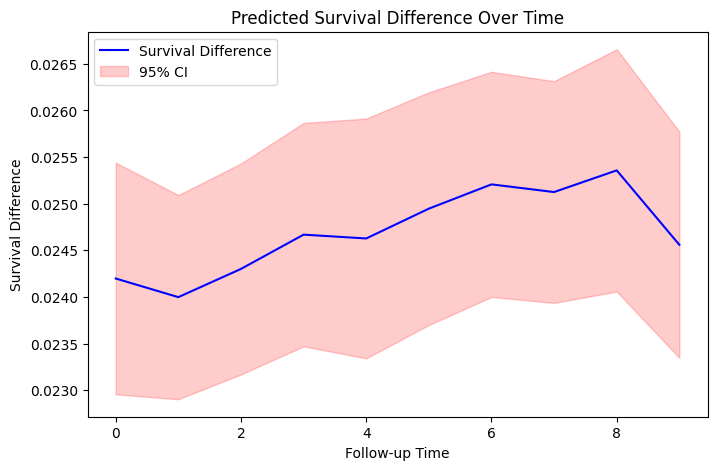

In [298]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def predict_survival(model, data, times=np.arange(0, 11)):
    """
    Predicts survival probabilities for control and treated groups over follow-up time.
    """
    # Copy data for treatment groups
    data_control = data.copy()
    data_control["assigned_treatment"] = 0  # Control group

    data_treated = data.copy()
    data_treated["assigned_treatment"] = 1  # Treated group

    # Predict probabilities using the logistic model
    preds_control = model.predict(data_control)
    preds_treated = model.predict(data_treated)

    # Compute survival probabilities (1 - risk)
    survival_control = 1 - preds_control
    survival_treated = 1 - preds_treated

    # Group by follow-up time
    survival_control = pd.DataFrame({"survival": survival_control, "followup_time": data_control["followup_time"]})
    survival_treated = pd.DataFrame({"survival": survival_treated, "followup_time": data_treated["followup_time"]})

    mean_control = survival_control.groupby("followup_time")["survival"].mean()
    mean_treated = survival_treated.groupby("followup_time")["survival"].mean()

    # Compute survival difference
    survival_diff = mean_treated - mean_control

    # Compute 95% Confidence Interval (CI)
    control_std = survival_control.groupby("followup_time")["survival"].std()
    treated_std = survival_treated.groupby("followup_time")["survival"].std()

    n_control = survival_control.groupby("followup_time")["survival"].count()
    n_treated = survival_treated.groupby("followup_time")["survival"].count()

    sem_control = control_std / np.sqrt(n_control)
    sem_treated = treated_std / np.sqrt(n_treated)

    ci_lower = survival_diff - 1.96 * np.sqrt(sem_control**2 + sem_treated**2)
    ci_upper = survival_diff + 1.96 * np.sqrt(sem_control**2 + sem_treated**2)

    # Plot results
    plt.figure(figsize=(8, 5))
    plt.plot(survival_diff.index, survival_diff, label="Survival Difference", color="blue")
    plt.fill_between(survival_diff.index, ci_lower, ci_upper, color="red", alpha=0.2, label="95% CI")

    plt.xlabel("Follow-up Time")
    plt.ylabel("Survival Difference")
    plt.title("Predicted Survival Difference Over Time")
    plt.legend()
    plt.show()

# Apply prediction
predict_survival(outcome_model_itt_msm, trial_itt_loaded)
